<img src="images/keepcoding.png" width=200 align="left">

# Módulo de Matemáticas 101: práctica

Vamos a poner de nuevo en práctica lo que hemos visto en este módulo. La práctica se centra en la regresión lineal (¡tema muy importante!) y podéis preguntarme las dudas que tengáis por Discord. ¡Mucha suerte!

<img src="./images/luck.gif" alt="Drawing" style="width: 300px;"/>

## 1. Regresión lineal con mínimos cuadrados

En este ejercicio vamos a implementar la forma matricial de la regresión lineal con el método de los mínimos cuadrados. Para ello, tendrás que:

- Explorar un dataset
- Implementar la regresión lineal
- Aplicarla a un dataset concreto

Como recordatorio, los valores de los pesos $\widehat{w}$ vienen dados por:

<center>$\widehat{w} = (X^T X)^{-1}X^T y,$</center>

Donde $y$ es la variable a predecir y $X$ la matriz de features (NOTA: revisa cómo se define en los apuntes). Sabemos que los pesos van a ser los parámetros de la ecuación lineal que estamos intentando ajustar y tendremos uno por cada variable de entrada que usemos y además un término independiente o bias.

### 1.1 Carga del dataset y exploración de datos

Vamos a usar el dataset de [Auto MPG](https://archive.ics.uci.edu/dataset/9/auto+mpg) que podemos encontrar en el [repositorio de Machine learning de UC Irvine](https://archive.ics.uci.edu/). Lo primero, vamos a familiarizarnos con los datos.

En el propio repositorio nos indican cómo descargar el dataset con su librería (podemos consultar el código fuente si queremos).

In [1]:
!pip install ucimlrepo

  Using cached ucimlrepo-0.0.7-py3-none-any.whl.metadata (5.5 kB)
Using cached ucimlrepo-0.0.7-py3-none-any.whl (8.0 kB)


In [12]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# metadata 
print(auto_mpg.metadata) 
  
# variable information 
print(auto_mpg.variables) 


{'uci_id': 9, 'name': 'Auto MPG', 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg', 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv', 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 398, 'num_features': 7, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': [], 'target_col': ['mpg'], 'index_col': ['car_name'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1993, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5859H', 'creators': ['R. Quinlan'], 'intro_paper': None, 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for th

Con la función `head` de Pandas podemos ver las primeras filas del dataset.

In [4]:
X.head()

,displacement,cylinders,horsepower,weight,acceleration,model_year,origin
0,307.0,8,130.0,3504,12.0,70,1
1,350.0,8,165.0,3693,11.5,70,1
2,318.0,8,150.0,3436,11.0,70,1
3,304.0,8,150.0,3433,12.0,70,1
4,302.0,8,140.0,3449,10.5,70,1


In [4]:
y.head()

,mpg
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0


En este punto, puedes hacer cualquier otro análisis exploratorio que creas conveniente.

In [16]:
# comprueba el tamaño del dataset
print(X.shape)
print(y.shape)

(398, 7)
(398, 1)


In [13]:
# Recuento de valores nulos por columna
print(X.isnull().sum()) 




displacement    0
cylinders       0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


In [14]:
"""
Se calcula la mediana de horsepower para rellenar campos nulos
"""
mediana_hp = X['horsepower'].median()
print("Mediana de horsepower:", mediana_hp)

X.loc[:, 'horsepower'] = X['horsepower'].fillna(mediana_hp)



Mediana de horsepower: 93.5


In [15]:
print(X['horsepower'].isnull().sum())  # Debería imprimir 0


0


    A continuación, crea una función a la que le pases los dataframes de features y de target y el nombre de la variable y haga la gráfica del target (consumo en millas por galón) vs la variable que le ha llegado por parámetro. Puedes ver un ejemplo de gráfica más abajo, pero usa los parámetros que quieras en cuanto a color de los puntos, grids etc.

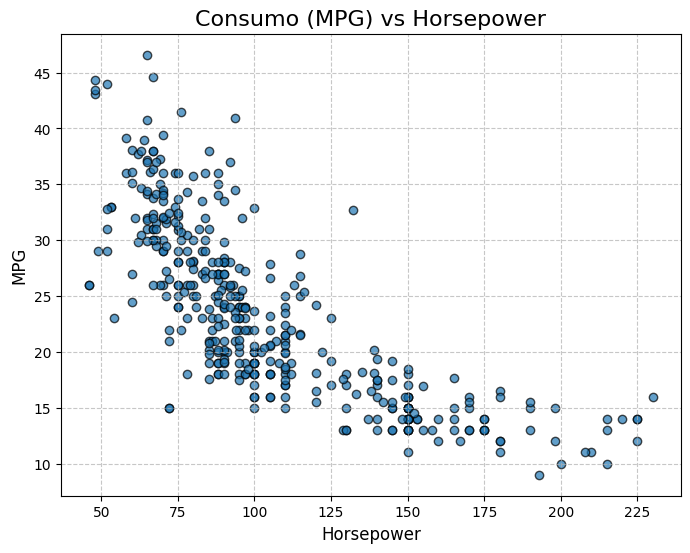

In [17]:
import matplotlib.pyplot as plt

def visualiza(df, y, nombre_columna):
    # Verificar que la columna existe
    if nombre_columna not in df.columns:
        print(f"Error: La columna '{nombre_columna}' no existe en el DataFrame.")
        return

    # Crear el gráfico de dispersión
    plt.figure(figsize=(8, 6))
    plt.scatter(df[nombre_columna], y, alpha=0.7, edgecolor='k')
    plt.title(f"Consumo (MPG) vs {nombre_columna.capitalize()}", fontsize=16)
    plt.xlabel(nombre_columna.capitalize(), fontsize=12)
    plt.ylabel("MPG", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    

visualiza(X, y, 'horsepower')

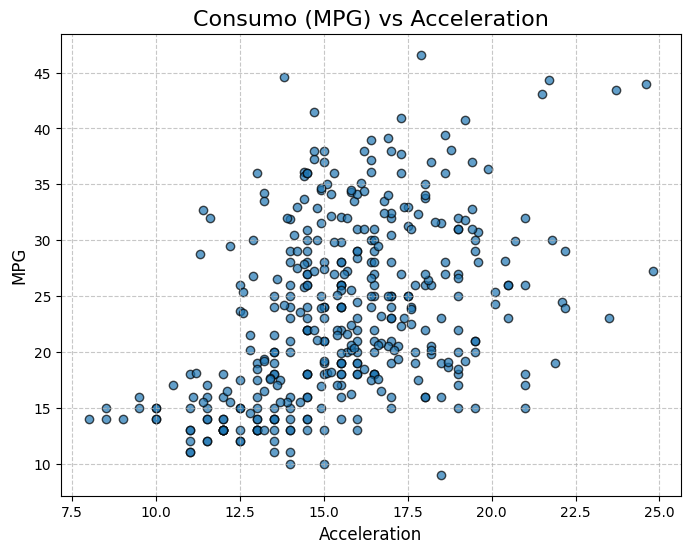

In [18]:
visualiza(X, y, 'acceleration')

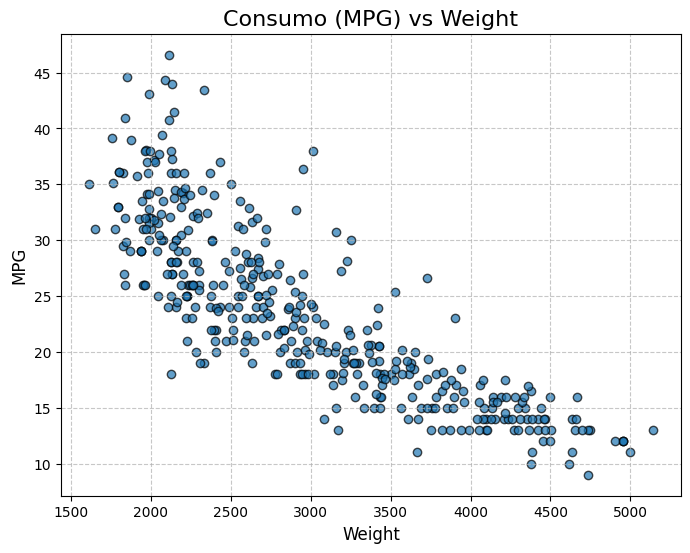

In [19]:
visualiza(X, y, 'weight')

IMPORTANTE: Aunque lo ideal sería un modelo multivariante, vamos a elegir la variable `weight` y hacer una regresión lineal solo con esta variable.

### 1.2 Implementación del modelo

En este punto vamos a dar un paso atrás y olvidarnos de los datos de consumo por un momento, porque el algoritmo que vamos a implementar serviría para cualquier conjunto de datos.

Lo primero, implementa una función que devuelva los valores de $\widehat{w}$ dados X e y. Si se da el caso de que el dataset tiene más features que observaciones, queremos transponerlo antes de realizar las operaciones. Lo hacemos porque, como vimos en clase, los resultados no van a ser buenos si el número de observaciones es menor.

In [20]:
import numpy as np

def pesos_ols(X, y):
    # Implementa la fórmula matricial
    
    # TODO 1 Comprueba que las dimensiones son adecuadas y corrige si no es así
    if X.shape[1] > X.shape[0]:
        X = X.T
    
    # TODO 2 Prepara la matriz X para que tenga la forma adecuada para aplicar la fórmula
    # Añade una columna de unos para el término independiente
    X = np.hstack((np.ones((X.shape[0], 1)), X))

    # TODO 3 Calcula los pesos
    # w = (X^T X)^(-1) X^T y
    w = np.linalg.inv(X.T @ X) @ X.T @ y

    return w

In [21]:
# Array de prueba!!
X = np.array([[1710, 1262, 1786, 1717, 2198, 1362, 1694, 2090, 1774, 1077], 
              [2003, 1976, 2001, 1915, 2000, 1993, 2004, 1973, 1931, 1939]])
y = np.array([208500, 181500, 223500, 140000, 250000, 143000, 307000, 200000, 129900, 118000])
pesos_ols(X, y)

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

Hemos implementado el algoritmo de mínimos cuadrados y lo hemos probado en un array de tamaño 2x10. Como pista, el resultado que he obtenido para este array de prueba es el siguiente:

array([-2.29223802e+06,  5.92536529e+01,  1.20780450e+03])

### 1.3 Prueba del modelo en los datos de consumo de coches

Ya podemos usar nuestra función `pesos` en el dataset real que hemos descargado, el de consumo de combustible. Para ver el ajuste, dibuja de nuevo los datos junto con la recta que has obtenido, en la misma gráfica. Tendrás que convertir los dataframes de Pandas en arrays de numpy para poder aplicar las operaciones matriciales.

TIP: Revisa las dimensiones de todos los arrays para ver que son correctas.

Dimensiones de X: (398, 1)
Dimensiones de y: (398, 1)
Coeficientes obtenidos: [[ 4.63173644e+01]
 [-7.67661006e-03]]


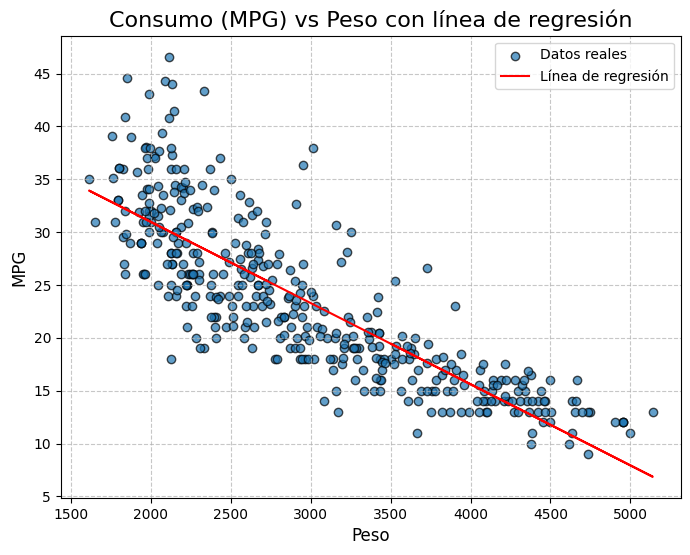

In [22]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

import numpy as np
import matplotlib.pyplot as plt

# Paso 1: Preparar los datos
# Seleccionar la variable weight como X y el consumo mpg como y
X = auto_mpg.data.features['weight'].to_numpy().reshape(-1, 1)  # Convertir a array numpy y asegurar 2D
y = auto_mpg.data.targets.to_numpy()  # Convertir a array numpy

# Verificar dimensiones
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

# Paso 2: Calcular los coeficientes
w = pesos_ols(X, y)
print("Coeficientes obtenidos:", w)

# Paso 3: Graficar los datos y la línea de regresión
plt.figure(figsize=(8, 6))
plt.scatter(X, y, alpha=0.7, edgecolor='k', label="Datos reales")  # Datos reales

# Generar los valores predichos usando la ecuación del modelo
y_pred = w[0] + w[1] * X

# Dibujar la línea de regresión
plt.plot(X, y_pred, color='red', label="Línea de regresión")

# Configuración del gráfico
plt.title("Consumo (MPG) vs Peso con línea de regresión", fontsize=16)
plt.xlabel("Peso", fontsize=12)
plt.ylabel("MPG", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()




Por último, vamos a comprar el resultado con el que nos da `scikit-learn`para ver si nuestra implementación tiene buena pinta. Podemos ver cómo funciona en la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

In [23]:
from sklearn.linear_model import LinearRegression

# Creamos el objeto
lr = LinearRegression()

# Le pasamos los datos en el formato correcto
X = auto_mpg.data.features 
y = auto_mpg.data.targets 

X_lr = X[['weight']]
y_lr = y

# Entrenamos con los datos
lr.fit(X_lr,y_lr)
print("Punto de corte:", lr.intercept_)
print("Pendiente:", lr.coef_)

Punto de corte: [46.31736442]
Pendiente: [[-0.00767661]]


**TODO**: Analiza el resultado obtenido y compáralo con el de sklearn

Los resultados obtenidos con Scikit-learn coinciden con los coeficientes que se calcularon manualmente usando la fórmula de mínimos cuadrados. Esto confirma que la implementación de la función pesos_ols es correcta.
Resultados:

Término independiente (𝑤0):

Fórmula manual: 46.3173644

Scikit-learn: 46.31736442

Pendiente (𝑤1):

Fórmula manual: −0.00767661

Scikit-learn:  −0.00767661

### 1.4 Compara el método de mínimos cuadrados y el descenso del gradiente para obtener los coeficientes de una regresión lineal



El método de mínimos cuadrados es una forma de ajustar la línea recta a los datos en regresión lineal. Su objetivo es encontrar la línea que minimiza la diferencia entre los valores reales y los valores predichos por el modelo. Esto lo hace calculando los coeficientes que mejor representan esa relación.

Por otro lado, el método de descenso del gradiente es una forma iterativa de encontrar los mejores coeficientes del modelo de regresión. En lugar de calcular todo de golpe como en los mínimos cuadrados, aquí se ajustan los coeficientes poco a poco siguiendo la pendiente (el gradiente) de la función de error.  El gradiente te dice hacia dónde está el mínimo de la función, y el metodo da pequeños pasos en esa dirección hasta llegar a dicho mínimo.

## 2. Optimización con descenso del gradiente [OPCIONAL]

Este ejercicio es opcional, no es necesario hacerlo para conseguir el APTO en la práctica, pero podéis hacerlo si queréis practicar más sobre el método del descenso del gradiente, que es muy importante en machine learning.

Vamos a resolver el mismo problema usando el descenso del gradiente en lugar de la solución analítica. El descenso del gradiente es un método de optimización iterativo que usa el operador gradiente.

Como es iterativo, necesitamos decirle cuándo tiene que parar y darnos la solución. En este caso, le vamos a decir que pare y nos devuelva la solución después de un número de iteraciones que le pasaremos como parámetro. La ecuación iterativa es.

$$w^{t+1} = w^t - \eta \cdot \nabla f(w)$$

donde f es nuestra función objetivo, y w es un vector. Para la función objetivo, vamos a usar el error RSS, que querremos minimizar.

$$ RSS(w) = \frac{1}{2}\sum_{n=1}^{N}[y_n-f(x_n)]^2$$

y cuyo gradiente es:

$$\nabla RSS(w) = X^T(Xw^t-y)$$

TIP: Ten en cuenta que el RSS también lo puedes escribir como $\frac{1}{2}\sum_{n=1}^{N}[y_n-\hat{y_n}]^2$ donde $\hat{y_n} = X \hat{w}$ en cada paso.

### 2.1 Implementar el descenso del gradiente

Completa las siguientes funciones para implementar el descenso del gradiente con la función objetivo de la regresión lineal. La función necesitará:

- La entrada X y salida y de la regresión
- Un punto inicial desde el que empezar a iterar
- El número de iteraciones 
- El learning rate

La función nos devolverá un array con las w resultantes de las iteraciones y otro con el valor de la función en cada paso del algoritmo, a la que también se conoce como *loss function*.

In [ ]:
import numpy as np

def gradient_descent(X, y, w0, n_iter, eta): 
    # Define la función que calcule n_iter iteraciones del descenso del gradiente
    # Inicializamos variables
    # Si eliges otra forma de resolverlo, puedes borrar esta parte
    loss_iter = [np.inf]
    w_iter = [w0]
    w = w0
    
    # TODO 1 Añade la columna de 1s
    
    
    # TODO 2 Haz un bucle para las iteraciones 
    # TODO 3 Dentro del bucle tendrás que actualizar el error y los pesos y añadirlos a las listas
    
    
    # Devuelve los resultados
    return np.array(w_iter), np.array(loss_iter)


eta = 0.01 
iteraciones = 2000 

np.random.seed(123)
w0 = np.random.rand(2).reshape((2,1))

y = np.array([208500, 181500, 223500, 140000, 250000]).reshape((5,1))
X = np.array( [[  0.37020659],
               [  -0.48234664],
               [  0.51483616],
               [  0.38352774],
               [  1.29888065]])

weights, loss = gradient_descent(X, y, w0, iteraciones, eta)

print(weights[-1])

### 2.2 Aplicar al dataset de consumo de combustible

Leemos de nuevo los datos y aplicamos la función que acabamos de programar.

In [62]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
# convert to numpy
X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy()

print(X_np.shape)
print(y_np.shape)

(398, 1)
(398, 1)


Para ayudar al algoritmo, vamos a escalar la variable X, restando la media y dividiendo entre la desviación estándar. Después aplicamos la función anterior y dibujamos.

In [ ]:
# TODO Aplica el modelo y dibuja la recta junto con los datos

X = auto_mpg.data.features
y = auto_mpg.data.targets

# Escalamos la variable x 

X_np = X['weight'].to_numpy().reshape((X.shape[0], 1))
y_np = y.to_numpy() 

X_gd=(X_np - X_np.mean()) / X_np.std()
y_gd = y_np

# TODO 1 Punto inicial y learning rate


# TODO 2 Aplicamos el algoritmo


# Límites de los ejes
x_max = np.max(X_gd) + 1
x_min = np.min(X_gd) -1


# TODO 3 Dibuja la gráfica
